In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision as vision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [2]:
class Decoder(nn.Module):
    '''
    Decoder network
    params:
        in_channels: input channels (from vq)
        num_hidden: hidden convolution channels
        residual_inter: intermediary residual block channels
    '''
    def __init__(self, in_channels, num_hidden, residual_inter):
        super(Decoder, self).__init__()
        
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=num_hidden,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.residual1 = Residual_block(
            in_channels=num_hidden,
            hidden_inter=residual_inter,
            hidden_final=num_hidden
        )
        self.residual2 = Residual_block(
            in_channels=num_hidden,
            hidden_inter=residual_inter,
            hidden_final=num_hidden
        )
        self.transpose1 = nn.ConvTranspose2d(
            in_channels=num_hidden,
            out_channels=num_hidden//2,
            kernel_size=4,
            stride=2,
            padding=1
        )
        self.transpose2 = nn.ConvTranspose2d(
            in_channels=num_hidden//2,
            out_channels=1,
            kernel_size=4,
            stride=2,
            padding=1
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.residual1(x)
        x = self.residual2(x)
        x = self.transpose1(x)
        x = self.transpose2(x)
        return x
    
class Encoder(nn.Module):
    '''
    Encoder block
    params:
        in_channels = input channels
        num_hidden = hidden blocks for encoder convolution
        residual_inter = intermediary residual block channels
    '''
    def __init__(self, in_channels, num_hidden, residual_inter):
        super(Encoder, self).__init__()

        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=num_hidden//2,
            kernel_size=4,
            stride=2,
            padding=1
        )
        self.conv2 = nn.Conv2d(
            in_channels=num_hidden//2,
            out_channels=num_hidden,
            kernel_size=4,
            stride=2,
            padding=1
        )
        self.residual1 = Residual_block(
            in_channels=num_hidden,
            hidden_inter=residual_inter,
            hidden_final=num_hidden
        )
        self.residual2 = Residual_block(
            in_channels=num_hidden,
            hidden_inter=residual_inter,
            hidden_final=num_hidden
        )
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.residual1(x)
        x = self.residual2(x)
        return x
    

class Residual_block(nn.Module):
    '''
    Create new Residual block
    Params:
        in_channels: Input channels
        hidden_inter: hidden channels for intermediate convolution
        hidden_final: Number of channels for output convolution
    '''
    def __init__(self, in_channels, hidden_inter, hidden_final):
        super(Residual_block, self).__init__()
        self.net = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=hidden_inter,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=False
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_inter,
                out_channels=hidden_final,
                kernel_size=1,
                stride=1,
                bias=False
            )
        )

    def forward(self, x):
        # Skip connection
        return x + self.net(x)
    

import torch 
import torch.nn as nn
import torch.nn.functional as F

class VectorQuantizer(nn.Module):
    """
    Create a Vector Quantizer module
    Params:
        num_embeddings: Number of embeddings in embeddings codebook
        embedding_dim: dim of each embedding in embeddings codebook
        commitment_cost: commitment term of the loss (beta in loss function)
    """
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        self.num_embeddings = num_embeddings 
        self.embedding_dim = embedding_dim

        # Create embedding table 
        self.embedding = nn.Embedding(self.num_embeddings, self.embedding_dim)
        # the learnable weights of the module of shape (num_embeddings, embedding_dim) initialized from \mathcal{N}(0, 1)N(0,1)
        self.embedding.weight.data.uniform_(-1/self.num_embeddings, 1/self.num_embeddings)
        self.commitment_cost = commitment_cost
    
    def forward(self, x):
        # convert inputs from BCHW to BHWC
        x = x.permute(0,2,3,1).contiguous() # keep memory contiguous
        x_shape = x.shape
        # Flatten
        # Each flattened layer is individually quantized
        flat_x = x.view(-1, self.embedding_dim)
        # Calculate distances
        # Find closest codebook vectors
        # find distance of encoded vector to all coded vectors
        # shape (#,num encodings)
        distances = (torch.sum(flat_x**2, dim=1, keepdim=True) 
                    + torch.sum(self.embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_x, self.embedding.weight.t()))
        
        # Encoding

        #return val for training 
        train_indices_return = torch.argmin(distances, dim=1)
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1) # min d

        encodings = torch.zeros(encoding_indices.shape[0], self.num_embeddings, device=x.device)
        encodings.scatter_(1, encoding_indices, 1) # place in encodings (eq to keras one-hot)
 
        # Quantize and unflatten
        # Multiply encodings table with embeddings
        quantized = torch.matmul(encodings, self.embedding.weight).view(x_shape)

        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), x) # stop gradient propogation on quantized
        q_latent_loss = F.mse_loss(quantized, x.detach()) 
        loss = q_latent_loss + self.commitment_cost * e_latent_loss # loss fn (paper)
        
        quantized = x + (quantized - x).detach() # when backprop end up with x (no gradient flow for other term) 
        
        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), encodings, train_indices_return

    """
    Returns embedding corresponding to encoding index
    For one index
    """
    def get_quantized(self, x):
        encoding_indices = x.unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self.num_embeddings, device=x.device)
        encodings.scatter_(1, encoding_indices, 1)
        quantized = torch.matmul(encodings, self.embedding.weight).view(1,64,64,64)
        return quantized.permute(0,3,1,2).contiguous()
    


class VQVAE(nn.Module):
    """
    VQVAE model
    params:
        num_hiddens: Hidden blocks for encoder convolutions
        residual_inter: Intermediary residual block channels
        num_embeddings: Number of codebook embeddings
        embedding_dim: Dimensions of each embedding
        commitment_cost: loss function beta value
    """
    def __init__(self, num_hiddens, residual_inter, 
                 num_embeddings, embedding_dim, commitment_cost):
        super(VQVAE, self).__init__()
        
        # Create the encoder
        self.encoder = Encoder(
            in_channels=1,
            num_hidden=num_hiddens, 
            residual_inter=residual_inter
        )

        # initial conv Convert input dimensions to embedding dimension
        self.conv1 = nn.Conv2d(
            in_channels=num_hiddens,
            out_channels=embedding_dim,
            kernel_size=1,
            stride=1
        )
       
        # Create vector qunatizer
        self.vq = VectorQuantizer(
            num_embeddings=num_embeddings, 
            embedding_dim=embedding_dim,
            commitment_cost=commitment_cost
        )
        
        # Create decoder
        self.decoder = Decoder(
            in_channels=embedding_dim,
            num_hidden=num_hiddens,
            residual_inter=residual_inter)

    def forward(self, x):
        # encode
        z = self.encoder(x)
        # change channel dim
        z = self.conv1(z)
        loss, quantized, _, _ = self.vq(z)
        # 64,64,64 quantized
        
        # decode
        x_recon = self.decoder(quantized) # reconstructed

        return loss, x_recon

In [21]:
x = torch.rand(1,1,256,256)

In [22]:
X2 = model.encoder(x)

In [24]:
X2.shape

torch.Size([1, 128, 64, 64])

In [25]:
x3 = model.conv1(X2)

In [26]:
x3.shape

torch.Size([1, 64, 64, 64])

In [27]:
x4 = model.vq(x3)

In [28]:
x4[1].shape

torch.Size([1, 64, 64, 64])

In [3]:
BATCH_SIZE = 32
EPOCHS = 20
LR = 1e-3
DEVICE = 'cuda'
device="cuda"
NUM_HIDDENS = 128 # hidden blocks for encoder convolution 
RESIDUAL_INTER = 32 # intermediary residual block channels
NUM_EMBEDDINGS = 512 # number of embeddings for codebook
EMBEDDING_DIM = 64 # dimension of each embedding
COMMITMENT_COST = 0.25 # beta term in loss function
TRAIN_DATA_PATH = '/home/Student/s4606685/summer_research/oasis-3/png_data' # path to training data
TEST_DATA_PATH = '/home/Student/s4606685/summer_research/oasis-3/png_data' # path to test data
DATA_VARIANCE = 0.0338 # evaluated seperately on training data

model = VQVAE(NUM_HIDDENS, RESIDUAL_INTER, NUM_EMBEDDINGS, EMBEDDING_DIM, COMMITMENT_COST)
model.to(DEVICE)
checkpoint = torch.load('/home/Student/s4606685/vqvae_11_1/model-vqvae-epoch_51.pth.tar')
model.load_state_dict(checkpoint['save_dic'])

<All keys matched successfully>

In [4]:
transform = transforms.Compose(
    [
        transforms.Resize((256,256)),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize(
            0.5, 0.5
        ),
    ]
)

test_ds = vision.datasets.ImageFolder(TEST_DATA_PATH, transform=transform)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True)

# Prior apprach idea
Train a wgan 
image --> WGAN --> quantized embedding

- Here the loss function of the wgan to be used as my p(z_q(x))
- Reconstruction from decoder, and Image loss = log(..) term
- log p(x) = prod of above

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # NxZx1x1 (z=128)
            nn.ConvTranspose2d(in_channels=128, out_channels=1024, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            # Nx1024x4x4
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # Nx512x8x8
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # Nx256x16x16
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # Nx128x32x32
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            #nn.Tanh()  # -1, 1
            # Nx3x64x64
        )

    def forward(self, x):
        return self.net(x)


class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.net = nn.Sequential(
            # Nx3x64x64
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2),
            # Nx128x32x32
            self._step(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1),
            # Nx256x16x16
            self._step(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1),
            self._step(in_channels=512, out_channels=1024, kernel_size=4, stride=2, padding=1),
            # Nx1024x4x4
            nn.Conv2d(in_channels=1024, out_channels=1, kernel_size=4, stride=2, padding=0),
            # Nx1x1x1
        )

    def _step(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride,
                      padding=padding, bias=False),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        return self.net(x)


def initialise(generator, discriminator):
    for l in generator.modules():
        if isinstance(l, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(l.weight.data, 0.0, 0.02)

    for l in discriminator.modules():
        if isinstance(l, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(l.weight.data, 0.0, 0.02)


def gradient_penalty(critic, real, fake, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penaltys = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penaltys


def save_checkpoint(checkpoint, filename="gan.pth.tar"):
    print("==> saving checkpoint ")
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_path, model):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['state_dic'])
    


In [10]:
LEARNING_RATE = 1e-4
BATCH_SIZE = 4
CHANNELS_IMG = 1
Z_DIM = 128
NUM_EPOCHS = 5
CRITIC_ITERATIONS = 5
WEIGHT_CLIP = 0.01
LAMBDA_GP = 10

In [11]:
transform = transforms.Compose(
    [
        transforms.Resize((256,256)),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize(
            0.5, 0.5
        ),
    ]
)

TRAIN_DATA_PATH = '/home/Student/s4606685/summer_research/oasis-3/png_data'
train_ds = vision.datasets.ImageFolder(TRAIN_DATA_PATH, transform=transform)
loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

In [16]:
gen = Generator().to(device)
critic = Critic().to(device)
initialise(gen, critic)

opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
opt_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))

fixed_noise = torch.randn(32, 128, 1, 1).to(device)
step = 0

for epoch in range(NUM_EPOCHS):
    for batch_idx, (data, _) in enumerate(loader):
        data = data.to(device)
        data = model.vq(model.conv1(model.encoder(data)))[1]
        cur_batch_size = data.shape[0]

        # Train Critic: max E[critic(real)] - E[critic(fake)]
        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(device)
            fake = gen(noise)
            critic_real = critic(data).reshape(-1)
            critic_fake = critic(fake).reshape(-1)
            gp = gradient_penalty(critic, data, fake, device=device)
            loss_critic = (
                    -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp
            )
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        gen_fake = critic(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Print losses occasionally and print to tensorboard
        if batch_idx % 100 == 0 and batch_idx > 0:
            gen.eval()
            critic.eval()
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(loader)} \
                  Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}"
            )

            step += 1
            gen.train()
            critic.train()

Epoch [0/5] Batch 100/26600                   Loss D: -5.7593, loss G: -42.7746
Epoch [0/5] Batch 200/26600                   Loss D: -7.7513, loss G: -62.9609
Epoch [0/5] Batch 300/26600                   Loss D: -5.5353, loss G: -64.6501
Epoch [0/5] Batch 400/26600                   Loss D: -29.4286, loss G: -59.5203
Epoch [0/5] Batch 500/26600                   Loss D: -17.2374, loss G: -133.7438
Epoch [0/5] Batch 600/26600                   Loss D: -22.8387, loss G: -123.2386
Epoch [0/5] Batch 700/26600                   Loss D: 45.8972, loss G: -143.9356
Epoch [0/5] Batch 800/26600                   Loss D: -22.6632, loss G: -141.5782


KeyboardInterrupt: 

In [18]:
noise = torch.rand(1,128,1,1)
gen=gen.to('cpu')
model=model.to('cpu')
quanti = gen(noise)


In [19]:
zzz = model.decoder(quanti)

In [20]:
import matplotlib.pyplot as plt

In [21]:
zzz.shape

torch.Size([1, 1, 256, 256])

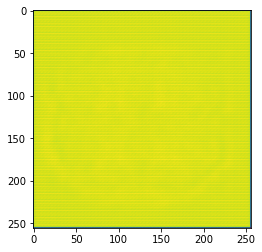

In [23]:
plt.imshow(zzz[0][0].detach())

In [15]:
cc = Generator()

In [16]:
z = torch.rand(1,128,1,1)
cc(z)

tensor([[[[-9.2992e-03,  5.5736e-02,  3.6504e-02,  ...,  6.5304e-02,
            3.3406e-02,  3.6902e-02],
          [ 4.1810e-02,  5.3821e-02,  1.0476e-02,  ..., -7.1828e-02,
            7.5043e-02, -6.0436e-02],
          [ 4.0213e-02, -6.2422e-02,  4.3896e-02,  ...,  8.5359e-02,
            3.1490e-02, -1.8094e-02],
          ...,
          [ 1.4205e-03, -1.9375e-02,  3.6692e-02,  ...,  7.9007e-03,
            1.0769e-02, -4.6720e-02],
          [ 6.0455e-03,  4.9647e-02, -6.2610e-02,  ...,  7.5770e-02,
            4.1337e-02, -2.0026e-02],
          [ 1.9206e-02, -1.3004e-03,  1.5983e-02,  ..., -4.6879e-02,
            2.8473e-02, -2.3930e-02]],

         [[-2.8546e-02, -1.7447e-02, -2.5160e-02,  ..., -5.2992e-02,
           -7.5621e-02,  4.3930e-02],
          [-8.8041e-02,  1.2166e-01, -2.0676e-01,  ...,  2.6611e-02,
           -4.7427e-02, -3.7037e-02],
          [-7.6708e-02,  7.7736e-02,  3.5901e-02,  ..., -7.9338e-02,
           -1.8208e-02,  7.6675e-02],
          ...,
     